# Setup

In [1]:
lapply(c('viridis', 'ggthemes', 'skimr'),
       function(pkg_name) { if(! pkg_name %in% installed.packages()) { install.packages(pkg_name)} } )

library(viridis)    # A nice color scheme for plots.
library(ggthemes)   # Common themes to change the look and feel of plots.
library(scales)     # Graphical scales map data to aesthetics in plots.
library(skimr)      # Better summaries of data.
library(lubridate)  # Date library from the tidyverse.
library(tidyverse)  # Data wrangling packages.
library(bigrquery)  # Data extraction from Google BigQuery
library(data.table )

# Load required libraries
library(dplyr)
library(tidyr)
library(purrr)
library(broom)

install.packages("pROC")
library(pROC)

## Plot setup.
theme_set(theme_bw(base_size = 14)) # Default theme for plots.

#' Returns a data frame with a y position and a label, for use annotating ggplot boxplots.
#'
#' @param d A data frame.
#' @return A data frame with column y as max and column label as length.
get_boxplot_fun_data <- function(df) {
  return(data.frame(y = max(df), label = stringr::str_c('N = ', length(df))))
}

# Get the bucket name
my_bucket <- Sys.getenv('WORKSPACE_BUCKET')
my_bucket

[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

Loading required package: viridisLite


Attaching package: ‘scales’


The following object is masked from ‘package:viridis’:

    viridis_pal



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr   1.1.4     ✔ readr   2.1.5
✔ forcats 1.0.0     ✔ stringr 1.5.1
✔ ggplot2 3.5.2     ✔ tibble  3.2.1
✔ purrr   1.0.4     ✔ tidyr   1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ readr::col_factor() masks scales::col_factor()
✖ purrr::discard()    masks scales::discard()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::lag()        masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is

[1] "gs://fc-secure-61ffe592-139f-4be1-8b47-8dbe2adbb1eb"

## Load and merge data

In [2]:
#Load demographic data
name_of_file_in_bucket <- 'Demographic_and_ancestry_covariates.csv'
system(paste0("gsutil cp ", my_bucket, "/data/", name_of_file_in_bucket, " ."), intern=T)
demo  <- read_csv(name_of_file_in_bucket) |> 
    select(-c(income, education)) |> 
    rename(age = age_at_last_event)

#Load SES data
name_of_file_in_bucket <- 'SES_data.csv'
system(paste0("gsutil cp ", my_bucket, "/data/", name_of_file_in_bucket, " ."), intern=T)
sdoh_data  <- read_csv(name_of_file_in_bucket)

#MERGE
demo_sdoh<-merge(demo, sdoh_data, on="person_id", how="inner")

#Load PRS data
name_of_file_in_bucket <- 'adjusted_PRS_scores.csv'
system(paste0("gsutil cp ", my_bucket, "/data/", name_of_file_in_bucket, " ."), intern=T)
PRS  <- read_csv(name_of_file_in_bucket) 

#MERGE
all_data_0<-merge(demo_sdoh, PRS, on="person_id", how="inner")

#Load Case control info 
name_of_file_in_bucket <- 'Case_Control_df.csv'
system(paste0("gsutil cp gs://fc-secure-672eeb92-4859-4ed9-9f59-d4349f3534a0/notebooks/Case_Control_df.csv ."), intern=T)
case_control  <- read_csv(name_of_file_in_bucket)

#MERGE
merged_data<-merge(all_data_0, case_control, on="person_id", how="left")

#Load PsRS data 
name_of_file_in_bucket <- 'individual_PsRS.csv'
system(paste0("gsutil cp ", my_bucket, "/data/", name_of_file_in_bucket, " ."), intern=T)
PsRS <- read_csv(name_of_file_in_bucket)
#For collaborators, will be done once with AoU trained weights and again with internally trained weights

#MERGE
merged_data<-merge(merged_data, PsRS, on="person_id", how="left")
colnames(merged_data)

character(0)

Rows: 135557 Columns: 51
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (9): SexGender, ancestry_pred, education, where_born, military, health...
dbl  (30): person_id, race_unknown, age_today, PC_1, PC_2, PC_3, PC_4, PC_5,...
lgl   (8): AIAN, Asian, Black, Mid, Multiple, PI, White, His
dttm  (1): basics_survey_datetime
date  (3): date_of_birth, min_date, max_date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


character(0)

Rows: 214915 Columns: 11
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (11): person_id, income, education, per_poverty_threshold, fraction_assi...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


character(0)

Rows: 135557 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): person_id, Asthma_adjusted_score, Afib_adjusted_score, BreastC_adju...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


character(0)

Rows: 265954 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (10): person_id, Asthma, Afib, BreastC, CKD, CHD, HyperC, ProstateC, t2d...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


character(0)

Rows: 104908 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): person_id, Afib_PsRS, Asthma_PsRS, BreastC_PsRS, CHD_PsRS, CKD_PsRS...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "person_id"                    "date_of_birth"               
 [3] "AIAN"                         "Asian"                       
 [5] "Black"                        "Mid"                         
 [7] "Multiple"                     "PI"                          
 [9] "White"                        "His"                         
[11] "race_unknown"                 "SexGender"                   
[13] "age_today"                    "ancestry_pred"               
[15] "PC_1"                         "PC_2"                        
[17] "PC_3"                         "PC_4"                        
[19] "PC_5"                         "PC_6"                        
[21] "PC_7"                         "PC_8"                        
[23] "PC_9"                         "PC_10"                       
[25] "PC_11"                        "PC_12"                       
[27] "PC_13"                        "PC_14"                       
[29] "PC_15"                        "PC_16"                       
[31] "number_living"                "where_born"                  
[33] "military"                     "healthcare"                  
[35] "disabled"                     "sexual_orientation"          
[37] "LGBTQIA"                      "basics_survey_datetime"      
[39] "income_grouped"               "min_date"                    
[41] "max_date"                     "ehr_length"                  
[43] "relative_health"              "record_depth"                
[45] "visit_frequency"              "age"                         
[47] "record_depth_winsorized"      "visit_frequency_winsorized"  
[49] "age2"                         "income"                      
[51] "education"                    "per_poverty_threshold"       
[53] "fraction_assisted_income"     "fraction_high_school_edu"    
[55] "median_income"                "fraction_no_health_insurance"
[57] "fraction_poverty"             "fraction_vacant_housing"     
[59] "deprivation_index"            "Asthma_adjusted_score"       
[61] "Afib_adjusted_score"          "BreastC_adjusted_score"      
[63] "CKD_adjusted_score"           "CHD_adjusted_score"          
[65] "ProstateC_adjusted_score"     "t1d_adjusted_score"          
[67] "t2d_adjusted_score"           "Asthma"                      
[69] "Afib"                         "BreastC"                     
[71] "CKD"                          "CHD"                         
[73] "HyperC"                       "ProstateC"                   
[75] "t2d"                          "t1d"                         
[77] "Afib_PsRS"                    "Asthma_PsRS"                 
[79] "BreastC_PsRS"                 "CHD_PsRS"                    
[81] "CKD_PsRS"                     "ProstateC_PsRS"              
[83] "t1d_PsRS"                     "t2d_PsRS"

In [3]:
merged_data <- merged_data %>%
  mutate(
    SexGenderCis_male = ifelse(SexGender == "Cis_male", 1, 0),
    SexGenderCis_female = ifelse(SexGender == "Cis_female", 1, 0),
    SexGenderSGM = ifelse(SexGender == "SGM", 1, 0)
  )

merged_data$age2<-merged_data$age^2

## Set up lists

In [4]:
diseases<-c("Asthma", "Afib", "BreastC", "CKD", "CHD", "ProstateC", "t2d", "t1d")

disease_name_mapping <- c(
    "Afib" = "Afib",
    "CKD" = "CKD", 
    "CHD" = "CHD",
  "t2d" = "T2D",
  "t1d" = "T1D",
    "BreastC" = "Breast\nCancer",
    "ProstateC" = "Prostate\nCancer"
)

# Regressions

## Models

In [5]:
# Model labels
models <- c("Base", "Genetic", "Social", "Joint", "Interaction")

# Function to generate formulas for disease-domain pairs
generate_formulas <- function(disease) {
  # Base covariates
  covariates <- c("age", "age2", "record_depth", "visit_frequency")
  
  # All possible sex terms
  sex_terms <- c("SexGenderCis_male", "SexGenderSGM")
  
  # Disease-specific exclusions
  if (disease == "CKD" || disease == "t1d") {
    sex_terms <- setdiff(sex_terms, "SexGenderSGM")
  }
  if (disease == "BreastC") {
    sex_terms <- setdiff(sex_terms, "SexGenderCis_male")
  }
  if (disease == "ProstateC") {
    sex_terms <- setdiff(sex_terms, "SexGenderCis_male")
  }

  # Combine covariates
  base <- paste(c(covariates, sex_terms), collapse = " + ")
  genetic_score <- paste0(disease, "_adjusted_score")
  polysocial_score <- paste0(disease, "_PsRS")
  interaction <- paste0(genetic_score, ":", polysocial_score)

  # Return all 5 models
  list(
    as.formula(paste(disease, "~", base)),
    as.formula(paste(disease, "~", paste(c(base, genetic_score), collapse = " + "))),
    as.formula(paste(disease, "~", paste(c(base, polysocial_score), collapse = " + "))),
    as.formula(paste(disease, "~", paste(c(base, genetic_score, polysocial_score), collapse = " + "))),
    as.formula(paste(disease, "~", paste(c(base, genetic_score, polysocial_score, interaction), collapse = " + ")))
  )
}

## Auc

In [6]:
fit_and_extract <- function(formulas, disease, models, data) {
  map2(formulas, models, ~ {
    # Disease-specific filtering
    filtered_data <- data
    if (disease %in% c("CKD", "t1d")) {
      filtered_data <- filtered_data %>% filter(SexGenderSGM == 0)
    }
    if (disease == "BreastC") {
      filtered_data <- filtered_data %>% filter(SexGenderCis_male == 0)
    }
    if (disease == "ProstateC") {
      filtered_data <- filtered_data %>% filter(SexGenderCis_female == 0)
    }

    # Handle missing vars
    vars_in_model <- all.vars(.x)
    filtered_data <- filtered_data %>% 
      filter(if_all(all_of(vars_in_model), ~ !is.na(.)))

    # Fit model
    model <- glm(.x, data = filtered_data, family = binomial(link = "logit"))

    # Predictions
    preds <- predict(model, type = "response")
    actuals <- model$y
    ids <- filtered_data$person_id

    # AUC + CI
    if (length(unique(actuals)) > 1) {
      roc_obj <- roc(actuals, preds, quiet = TRUE)
      auc <- as.numeric(roc_obj$auc)
      auc_ci <- ci.auc(roc_obj)
    } else {
      auc <- NA
      auc_ci <- c(NA, NA, NA)
    }

    list(
      coefficients = tidy(model) %>%
        mutate(Disease = disease,
               Model = .y,
               AUC = auc,
               AUC_CI_Lower = auc_ci[1],
               AUC_CI_Upper = auc_ci[3]),
      predictions = tibble(
        person_id = ids,
        actual = actuals,
        prediction = preds,
        Disease = disease,
        Model = .y
      )
    )
  })
}

results <- tibble(disease = diseases) %>%
  rowwise() %>%
  mutate(model_results = list(
    fit_and_extract(generate_formulas(disease), disease, models, merged_data)
  )) %>%
  ungroup()


# All coefficients
coeff_results <- results %>%
  mutate(coeffs = map(model_results, ~ bind_rows(map(.x, "coefficients")))) %>%
  select(disease, coeffs) %>%
  unnest(coeffs)

# All predictions
pred_results <- results %>%
  mutate(preds = map(model_results, ~ bind_rows(map(.x, "predictions")))) %>%
  select(disease, preds) %>%
  unnest(preds)



Warning message:
“There were 5 warnings in `mutate()`.
The first warning was:
ℹ In argument: `model_results = list(...)`.
ℹ In row 1.
Caused by warning:
! glm.fit: fitted probabilities numerically 0 or 1 occurred
ℹ Run `dplyr::last_dplyr_warnings()` to see the 4 remaining warnings.”


In [7]:
# Step 2: Join domain lookup and restrict all models to the mapped domain
auc_plot_data <- coeff_results %>%
  filter(Model %in% c("Base", "Genetic", "Social", "Joint", "Interaction")) %>%
  filter(!is.na(AUC)) %>%
  select(Disease, Model, AUC, AUC_CI_Lower, AUC_CI_Upper) %>%
  distinct()


model_colors <- c(
  "Base"    = "#E69F00", # orange
  "Genetic" = "#0072B2", # blue
  "Social"  = "#009E73", # bluish green
  "Joint"   = "#D55E00", # vermillion
  "Interaction" = "grey"
)


# Map names
auc_plot_data <- auc_plot_data  %>% mutate(Disease = as.character(Disease), 
                                                    Disease = recode(Disease, 
                                                    !!!disease_name_mapping, 
                                                                     .default = Disease) )

In [8]:
facet_order <- c(
  "Breast\nCancer", "Prostate\nCancer", "Afib", "T2D",
  "CKD", "CHD", "Asthma", "T1D"
)

auc_plot_data <- auc_plot_data %>%
  mutate(
    Model = factor(Model, c("Base", "Social", "Genetic",
                                    "Joint", "Interaction")),
    Disease = factor(Disease, facet_order)
  )


# Create the plot
auc_plot <- ggplot(auc_plot_data, aes(x = Disease, y = AUC, color = Model)) +
  geom_point(position = position_dodge(width = 0.7), size = 3.5) +  # Points for AUC
  geom_errorbar(aes(ymin = AUC_CI_Lower, ymax = AUC_CI_Upper), 
                position = position_dodge(width = 0.7), width = 0.4) +  # Error bars for 95% CI
  scale_color_brewer(palette = "Set1", name = "Model") +  # Color by Model
  labs(
    title = " ",
    x = " ",
    y = "AUC"
  ) +
  theme_minimal(base_size = 24) +
 theme(legend.position = "top") + 
 scale_color_manual(values = model_colors) + 
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    strip.text = element_text(size = 12, face = "bold"),
    legend.title = element_text(face = "bold", hjust=.5),
    panel.grid.major.x = element_blank(),
    panel.grid.major.y = element_line(size = 0.1, color = "black")
  ) +
  geom_vline(xintercept = seq(1.5, length(unique(auc_plot_data$Disease)) - 0.5, 1),
             color = "darkgrey")

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


## DeLong's Test of Significance 

In [9]:
compare_models_auc <- function(df, disease_name) {
    
  #Get the models we will be comparing 
  models <- unique(df$Model)
    
  #Compare two at a time - make combinations
  comparisons <- combn(models, 2, simplify = FALSE)
  
  #Compute significance using roc.test
  map_dfr(comparisons, function(comp) {
    m1 <- comp[1]; m2 <- comp[2]
    
    roc1 <- roc(df$actual[df$Model == m1],
                df$prediction[df$Model == m1],
                quiet = TRUE)
    roc2 <- roc(df$actual[df$Model == m2],
                df$prediction[df$Model == m2],
                quiet = TRUE)
    
    test <- roc.test(roc1, roc2, method = "delong")
      
    se1 <- as.numeric(ci.auc(roc1, conf.level = 0.95)[3] - ci.auc(roc1, conf.level = 0.95)[2]) / 3.92
    se2 <- as.numeric(ci.auc(roc2, conf.level = 0.95)[3] - ci.auc(roc2, conf.level = 0.95)[2]) / 3.92
  
    
    tibble(
      Disease = disease_name,
      Model1 = m1,
      Model2 = m2,
      AUC1 = as.numeric(auc(roc1)),
      se1 = se1,
      se2 = se2,
      AUC2 = as.numeric(auc(roc2)), 
      p_value = test$p.value
    )
  })
}

auc_comparisons <- pred_results %>%
  group_by(Disease) %>%
  group_map(~ compare_models_auc(.x, .y$Disease)) %>%
  bind_rows()



auc_comparisons <- auc_comparisons %>%
  mutate(
    bonf_p = 0.05 / nrow(auc_comparisons),      # Bonferroni threshold
    p_value_bonf = p_value * nrow(auc_comparisons), # adjusted p-value
    p_value_bonf = ifelse(p_value_bonf > 1, 1, p_value_bonf), # cap at 1
    significant = p_value < bonf_p,              # TRUE/FALSE flag
    level = case_when(
      p_value_bonf < 0.05e-10 ~ "***",
      p_value_bonf < 0.05  ~ "**",
      p_value < 0.05  ~ "*",
      TRUE ~ ""
    )
  )

# Map names
auc_comparisons <- auc_comparisons  %>% mutate(Disease = as.character(Disease), 
                                                    Disease = recode(Disease, 
                                                    !!!disease_name_mapping, 
                                                                     .default = Disease) )


write_excel_csv(auc_comparisons, "auc_comparisons_sdoh_joint_modeling.csv")
system(paste0("gsutil cp ./auc_comparisons_sdoh_joint_modeling.csv ", my_bucket, "/data/"), intern=T)

nrow(auc_comparisons)


character(0)

[1] 80

# Plot 

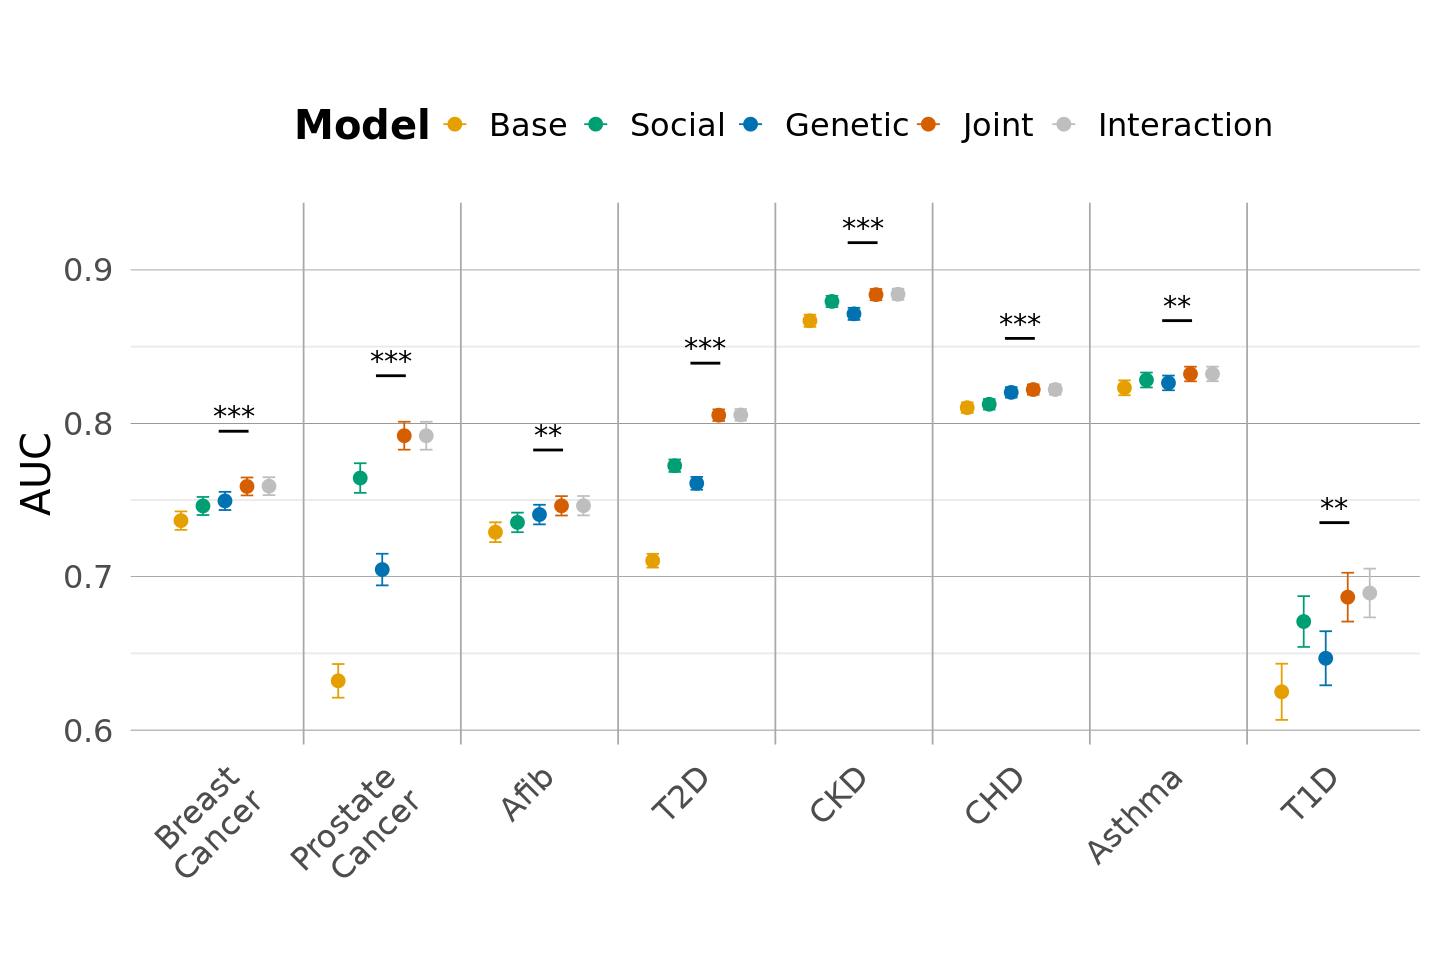

In [10]:
auc_comparisons <- auc_comparisons %>% 
 mutate(
    Disease = factor(Disease, facet_order)
  )

gen_joint_lines <- auc_comparisons %>%
  filter(
    (Model1 == "Genetic" & Model2 == "Joint") |
    (Model1 == "Joint" & Model2 == "Genetic")
  ) %>%
  left_join(
    auc_plot_data %>%
      group_by(Disease) %>%
      summarize(y = max(AUC_CI_Upper, na.rm = TRUE)),
    by = "Disease"
  ) %>%
  mutate(
    y = y + 0.03,        # vertical offset above CI
    x_start = as.numeric(factor(Disease)) - 0.04,
    x_end   = as.numeric(factor(Disease)) + 0.15
  )

auc_plot <- auc_plot +
  geom_segment(
    data = gen_joint_lines,
    aes(x = x_start, xend = x_end, y = y, yend = y),
    inherit.aes = FALSE,
    linewidth = 0.8
  ) +
  geom_text(
    data = gen_joint_lines,
    aes(x = (x_start + x_end) / 2, y = y + 0.01, label = level),
    inherit.aes = FALSE,
    size = 6
  )

# Set plot size for Jupyter Notebook
options(repr.plot.width = 12, repr.plot.height = 8)  # Set width and height
print(auc_plot)

# Save the plot (optional)
ggsave("auc_plot_with_ci.png", plot = auc_plot, width = 12, height = 8, dpi = 300)

# RE RUN control for PCs

In [11]:
# Model labels
models <- c("Base", "Genetic", "Social", "Joint", "Interaction")

# Function to generate formulas for disease-domain pairs
generate_formulas <- function(disease) {
  # Base covariates
  covariates <- c("age", "age2", "record_depth", "visit_frequency")
  
  # All possible sex terms
  sex_terms <- c("SexGenderCis_male", "SexGenderSGM")
  
  # Disease-specific exclusions
  if (disease == "CKD" || disease == "t1d") {
    sex_terms <- setdiff(sex_terms, "SexGenderSGM")
  }
  if (disease == "BreastC") {
    sex_terms <- setdiff(sex_terms, "SexGenderCis_male")
  }
  if (disease == "ProstateC") {
    sex_terms <- setdiff(sex_terms, "SexGenderCis_male")
  }

  # Combine covariates
  base <- paste(c(covariates, sex_terms), collapse = " + ")
  genetic_score <- paste0(disease, "_adjusted_score")
  polysocial_score <- paste0(disease, "_PsRS")
  interaction <- paste0(genetic_score, ":", polysocial_score)

  # Return all 5 models
  list(
    as.formula(paste(disease, "~", base)),
    #as.formula(paste(disease, "~", paste(c(base, genetic_score), collapse = " + "))),
    as.formula(paste(disease, "~", paste(c(base, genetic_score, paste0("PC_", 1:16)), collapse = " + "))),
    as.formula(paste(disease, "~", paste(c(base, polysocial_score), collapse = " + "))),
    #as.formula(paste(disease, "~", paste(c(base, genetic_score, polysocial_score), collapse = " + "))),
    as.formula(paste(disease, "~", paste(c(base, genetic_score, paste0("PC_", 1:16), polysocial_score), collapse = " + "))),
    #as.formula(paste(disease, "~", paste(c(base, genetic_score, polysocial_score, interaction), collapse = " + ")))
    as.formula(paste(disease, "~", paste(c(base, genetic_score, paste0("PC_", 1:16), polysocial_score, interaction), collapse = " + ")))
 

  )
}

results <- tibble(disease = diseases) %>%
  rowwise() %>%
  mutate(model_results = list(
    fit_and_extract(generate_formulas(disease), disease, models, merged_data)
  )) %>%
  ungroup()


# All coefficients
coeff_results <- results %>%
  mutate(coeffs = map(model_results, ~ bind_rows(map(.x, "coefficients")))) %>%
  select(disease, coeffs) %>%
  unnest(coeffs)

# All predictions
pred_results <- results %>%
  mutate(preds = map(model_results, ~ bind_rows(map(.x, "predictions")))) %>%
  select(disease, preds) %>%
  unnest(preds)



Warning message:
“There were 5 warnings in `mutate()`.
The first warning was:
ℹ In argument: `model_results = list(...)`.
ℹ In row 1.
Caused by warning:
! glm.fit: fitted probabilities numerically 0 or 1 occurred
ℹ Run `dplyr::last_dplyr_warnings()` to see the 4 remaining warnings.”


In [12]:
# Step 2: Join domain lookup and restrict all models to the mapped domain
auc_plot_data <- coeff_results %>%
  filter(Model %in% c("Base", "Genetic", "Social", "Joint", "Interaction")) %>%
  filter(!is.na(AUC)) %>%
  select(Disease, Model, AUC, AUC_CI_Lower, AUC_CI_Upper) %>%
  distinct()


model_colors <- c(
  "Base"    = "#E69F00", # orange
  "Genetic" = "#0072B2", # blue
  "Social"  = "#009E73", # bluish green
  "Joint"   = "#D55E00", # vermillion
  "Interaction" = "grey"
)


# Map names
auc_plot_data <- auc_plot_data  %>% mutate(Disease = as.character(Disease), 
                                                    Disease = recode(Disease, 
                                                    !!!disease_name_mapping, 
                                                                     .default = Disease) )

facet_order <- c(
  "Breast\nCancer", "Prostate\nCancer", "Afib", "T2D",
  "CKD", "CHD", "Asthma", "T1D"
)

auc_plot_data <- auc_plot_data %>%
  mutate(
    Model = factor(Model, c("Base", "Social", "Genetic",
                                    "Joint", "Interaction")),
    Disease = factor(Disease, facet_order)
  )


# Create the plot
auc_plot <- ggplot(auc_plot_data, aes(x = Disease, y = AUC, color = Model)) +
  geom_point(position = position_dodge(width = 0.7), size = 3.5) +  # Points for AUC
  geom_errorbar(aes(ymin = AUC_CI_Lower, ymax = AUC_CI_Upper), 
                position = position_dodge(width = 0.7), width = 0.4) +  # Error bars for 95% CI
  scale_color_brewer(palette = "Set1", name = "Model") +  # Color by Model
  labs(
    title = " ",
    x = " ",
    y = "AUC"
  ) +
  theme_minimal(base_size = 24) +
 theme(legend.position = "top") + 
 scale_color_manual(values = model_colors) + 
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    strip.text = element_text(size = 12, face = "bold"),
    legend.title = element_text(face = "bold", hjust=.5),
    panel.grid.major.x = element_blank(),
    panel.grid.major.y = element_line(size = 0.1, color = "black")
  ) +
  geom_vline(xintercept = seq(1.5, length(unique(auc_plot_data$Disease)) - 0.5, 1),
             color = "darkgrey")



Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


In [13]:
auc_comparisons <- pred_results %>%
  group_by(Disease) %>%
  group_map(~ compare_models_auc(.x, .y$Disease)) %>%
  bind_rows()



auc_comparisons <- auc_comparisons %>%
  mutate(
    bonf_p = 0.05 / nrow(auc_comparisons),      # Bonferroni threshold
    p_value_bonf = p_value * nrow(auc_comparisons), # adjusted p-value
    p_value_bonf = ifelse(p_value_bonf > 1, 1, p_value_bonf), # cap at 1
    significant = p_value < bonf_p,              # TRUE/FALSE flag
    level = case_when(
      p_value_bonf < 0.05e-10 ~ "***",
      p_value_bonf < 0.05  ~ "**",
      p_value < 0.05  ~ "*",
      TRUE ~ ""
    )
  )

# Map names
auc_comparisons <- auc_comparisons  %>% mutate(Disease = as.character(Disease), 
                                                    Disease = recode(Disease, 
                                                    !!!disease_name_mapping, 
                                                                     .default = Disease) )


write_excel_csv(auc_comparisons, "auc_comparisons_sdoh_joint_modeling_PCs.csv")
system(paste0("gsutil cp ./auc_comparisons_sdoh_joint_modeling_PCs.csv ", my_bucket, "/data/"), intern=T)


character(0)

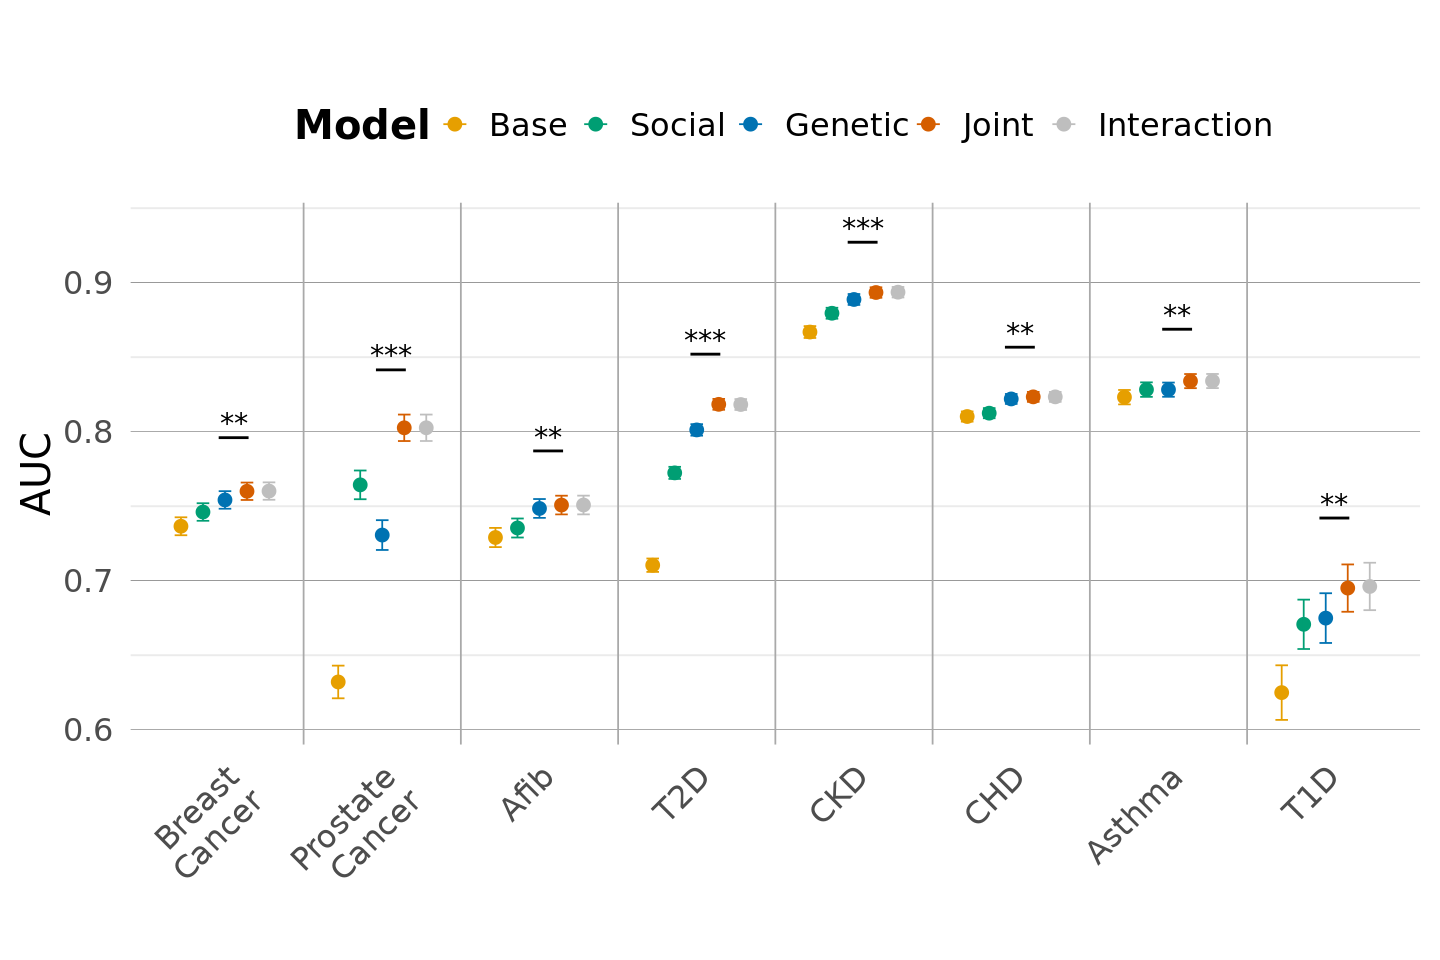

In [14]:
auc_comparisons <- auc_comparisons %>% 
 mutate(
    Disease = factor(Disease, facet_order)
  )

gen_joint_lines <- auc_comparisons %>%
  filter(
    (Model1 == "Genetic" & Model2 == "Joint") |
    (Model1 == "Joint" & Model2 == "Genetic")
  ) %>%
  left_join(
    auc_plot_data %>%
      group_by(Disease) %>%
      summarize(y = max(AUC_CI_Upper, na.rm = TRUE)),
    by = "Disease"
  ) %>%
  mutate(
    y = y + 0.03,        # vertical offset above CI
    x_start = as.numeric(factor(Disease)) - 0.04,
    x_end   = as.numeric(factor(Disease)) + 0.15
  )

auc_plot <- auc_plot +
  geom_segment(
    data = gen_joint_lines,
    aes(x = x_start, xend = x_end, y = y, yend = y),
    inherit.aes = FALSE,
    linewidth = 0.8
  ) +
  geom_text(
    data = gen_joint_lines,
    aes(x = (x_start + x_end) / 2, y = y + 0.01, label = level),
    inherit.aes = FALSE,
    size = 6
  )

# Set plot size for Jupyter Notebook
options(repr.plot.width = 12, repr.plot.height = 8)  # Set width and height
print(auc_plot)

# Save the plot (optional)
ggsave("auc_plot_with_ci_PCs.png", plot = auc_plot, width = 12, height = 8, dpi = 300)
